<h2 align=left> Finetuning a Tensorflow BERT model for Text Classification</h2>

<div align="center">
    <img width="512px" src='https://drive.google.com/uc?id=1fnJTeJs5HUpz7nix-F9E6EZdgUflqyEu' />
    <p style="text-align: center;color:gray">Figure 1: BERT Classification Model</p>
</div>

<div align="center">
    <img width="512px" src='https://miro.medium.com/max/1400/1*GVcm-gUJ5r6niWB6OsOg_w.png' />
    <p style="text-align: center;color:gray">Figure 1.1: Transfer Learning for Natural Language Modeling</p>
</div>

In this project, we will use TensorFlow and TF-Hub.

The pretrained BERT model used in this project is [available](https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/2) on TensorFlow Hub

## Setting up TensorFlow and Colab Runtime.

In [ ]:
# Checking GPU availability
!nvidia-smi

Sun Dec  4 05:57:50 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   56C    P0    30W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### Installing TensorFlow and TensorFlow Model Garden

In [ ]:
import tensorflow as tf
print(tf.version.VERSION)

2.9.2


In [ ]:
!git clone --depth 1 -b v2.3.0 https://github.com/tensorflow/models.git

Cloning into 'models'...
remote: Enumerating objects: 2650, done.
remote: Counting objects: 100% (2650/2650), done.
remote: Compressing objects: 100% (2311/2311), done.
remote: Total 2650 (delta 505), reused 1389 (delta 306), pack-reused 0
Receiving objects: 100% (2650/2650), 34.02 MiB | 10.91 MiB/s, done.
Resolving deltas: 100% (505/505), done.
Note: checking out '400d68abbccda2f0f6609e3a924467718b144233'.

You are in 'detached HEAD' state. You can look around, make experimental
changes and commit them, and you can discard any commits you make in this
state without impacting any branches by performing another checkout.

If you want to create a new branch to retain commits you create, you may
do so (now or later) by using -b with the checkout command again. Example:

  git checkout -b <new-branch-name>



In [ ]:
# installing requirements to use tensorflow/models repository
!pip install -Uqr models/official/requirements.txt


     |████████████████████████████████| 10.6 MB 13.5 MB/s 
     |████████████████████████████████| 212 kB 68.3 MB/s 
     |████████████████████████████████| 17.1 MB 58 kB/s 
     |████████████████████████████████| 12.2 MB 24.1 MB/s 
     |████████████████████████████████| 280 kB 10.8 MB/s 
     |████████████████████████████████| 33.8 MB 176 kB/s 
     |████████████████████████████████| 238 kB 70.6 MB/s 
     |████████████████████████████████| 4.7 MB 60.3 MB/s 
     |████████████████████████████████| 1.1 MB 68.3 MB/s 
     |████████████████████████████████| 352 kB 79.1 MB/s 
     |████████████████████████████████| 1.3 MB 64.7 MB/s 
     |████████████████████████████████| 9.4 MB 50.2 MB/s 
     |████████████████████████████████| 3.2 MB 57.6 MB/s 
     |████████████████████████████████| 965 kB 65.2 MB/s 
     |████████████████████████████████| 295 kB 79.2 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the 

### Restart the runtime

## Download and Import the Quora Insincere Questions Dataset

In [ ]:
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
import sys
sys.path.append('models')
from official.nlp.data import classifier_data_lib
from official.nlp.bert import tokenization
from official.nlp import optimization

In [ ]:
print("TF Version: ", tf.__version__)
print("Eager mode: ", tf.executing_eagerly())
print("Hub version: ", hub.__version__)
print("GPU is", "available" if tf.config.experimental.list_physical_devices("GPU") else "NOT AVAILABLE")

TF Version:  2.9.2
Eager mode:  True
Hub version:  0.12.0
GPU is available


In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

df = pd.read_csv('https://archive.org/download/fine-tune-bert-tensorflow-train.csv/train.csv.zip',
                 compression='zip', low_memory=False)
df.shape

(1306122, 3)

In [ ]:
df.tail(20)

,qid,question_text,target
1306102,ffff3778790af9baae76,What steps can I take to live a normal life if...,0
1306103,ffff3f0a2449ffe4b9ff,Isn't Trump right after all? Why should the US...,1
1306104,ffff41393389d4206066,Is 33 too late for a career in creative advert...,0
1306105,ffff42493fc203cd9532,What is difference between the filteration wor...,0
1306106,ffff48dd47bee89fff79,"If the universe ""popped"" into existence from n...",0
1306107,ffff5fd051a032f32a39,How does a shared service technology team meas...,0
1306108,ffff6d528040d3888b93,How is DSATM civil engineering?,0
1306109,ffff8776cd30cdc8d7f8,Do you know any problem that depends solely on...,0
1306110,ffff94d427ade3716cd1,What are some comic ideas for you Tube videos ...,0
1306111,ffffa382c58368071dc9,"If you had $10 million of Bitcoin, could you s...",0


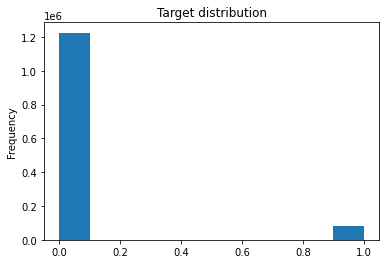

In [ ]:
# Plotting the distribution of sincere vs insincere questions; as can be seen, there is a lot of imbalance
df.target.plot(kind='hist', title='Target distribution');

## Creating tf.data.Datasets for Training and Evaluation

In [ ]:
train_df, remaining = train_test_split(df, random_state=42, train_size=0.0075, stratify=df.target.values)
valid_df, _ = train_test_split(remaining, random_state=42, train_size=0.00075, stratify=remaining.target.values)
train_df.shape, valid_df.shape

((9795, 3), (972, 3))

In [ ]:
with tf.device('/cpu:0'):
  train_data = tf.data.Dataset.from_tensor_slices((train_df.question_text.values, train_df.target.values))
  valid_data = tf.data.Dataset.from_tensor_slices((valid_df.question_text.values, valid_df.target.values))

  for text, label in train_data.take(1):
    print(text)
    print(label)

tf.Tensor(b'Why are unhealthy relationships so desirable?', shape=(), dtype=string)
tf.Tensor(0, shape=(), dtype=int64)


## Task 5: Download a Pre-trained BERT Model from TensorFlow Hub

In [ ]:
"""
Each line of the dataset is composed of the review text and its label
- Data preprocessing consists of transforming text to BERT input features:
input_word_ids, input_mask, segment_ids
- In the process, tokenizing the text is done with the provided BERT model tokenizer
"""

label_list = [0, 1] # Label categories
max_seq_length = 128 # maximum length of (token) input sequences
train_batch_size = 32

# Get BERT layer and tokenizer:

bert_layer = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/2",
                            trainable=True)
vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
do_lower_case = bert_layer.resolved_object.do_lower_case.numpy()
tokenizer = tokenization.FullTokenizer(vocab_file, do_lower_case)

In [ ]:
tokenizer.wordpiece_tokenizer.tokenize('hi, how are you doing?')

['hi', '##,', 'how', 'are', 'you', 'doing', '##?']

In [ ]:
tokenizer.convert_tokens_to_ids(tokenizer.wordpiece_tokenizer.tokenize('hi, how are you doing?'))

[7632, 29623, 2129, 2024, 2017, 2725, 29632]

## Task 6: Tokenize and Preprocess Text for BERT

<div align="center">
    <img width="512px" src='https://drive.google.com/uc?id=1-SpKFELnEvBMBqO7h3iypo8q9uUUo96P' />
    <p style="text-align: center;color:gray">Figure 2: BERT Tokenizer</p>
</div>

We'll need to transform our data into a format BERT understands. This involves two steps. First, we create InputExamples using `classifier_data_lib`'s constructor `InputExample` provided in the BERT library.

In [ ]:
# This provides a function to convert row to input features and label

def to_feature(text, label, label_list=label_list, max_seq_length=max_seq_length, tokenizer=tokenizer):
  example = classifier_data_lib.InputExample(guid = None,
                                            text_a = text.numpy(), 
                                            text_b = None, 
                                            label = label.numpy())
  feature = classifier_data_lib.convert_single_example(0, example, label_list,
                                    max_seq_length, tokenizer)
  
  return (feature.input_ids, feature.input_mask, feature.segment_ids, feature.label_id)

We want to use [`Dataset.map`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#map) to apply this function to each element of the dataset. [`Dataset.map`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#map) runs in graph mode.

- Graph tensors do not have a value.
- In graph mode we can only use TensorFlow Ops and functions.

Therefore, we cannot `.map` this function directly: we need to wrap it in a [`tf.py_function`](https://www.tensorflow.org/api_docs/python/tf/py_function). The [`tf.py_function`](https://www.tensorflow.org/api_docs/python/tf/py_function) will pass regular tensors (with a value and a `.numpy()` method to access it), to the wrapped python function.

## Wrap a Python Function into a TensorFlow Ops for Eager Execution

In [ ]:
def to_feature_map(text, label):
  input_ids, input_mask, segment_ids, label_id = tf.py_function(to_feature, inp=[text, label], 
                                Tout=[tf.int32, tf.int32, tf.int32, tf.int32])

  # py_func doesn't set the shape of the returned tensors.
  input_ids.set_shape([max_seq_length])
  input_mask.set_shape([max_seq_length])
  segment_ids.set_shape([max_seq_length])
  label_id.set_shape([])

  x = {
        'input_word_ids': input_ids,
        'input_mask': input_mask,
        'input_type_ids': segment_ids
    }
  return (x, label_id)

## Create a TensorFlow Input Pipeline with `tf.data`

In [ ]:
with tf.device('/cpu:0'):
  # train
  train_data = (train_data.map(to_feature_map,
                              num_parallel_calls=tf.data.experimental.AUTOTUNE)
                          #.cache()
                          .shuffle(1000)
                          .batch(32, drop_remainder=True)
                          .prefetch(tf.data.experimental.AUTOTUNE))

  # valid
  valid_data = (valid_data.map(to_feature_map,
                            num_parallel_calls=tf.data.experimental.AUTOTUNE)
                          .batch(32, drop_remainder=True)
                          .prefetch(tf.data.experimental.AUTOTUNE)) 

The resulting `tf.data.Datasets` return `(features, labels)` pairs, as expected by [`keras.Model.fit`](https://www.tensorflow.org/api_docs/python/tf/keras/Model#fit):

In [ ]:
# data spec
train_data.element_spec

({'input_word_ids': TensorSpec(shape=(32, 128), dtype=tf.int32, name=None),
  'input_mask': TensorSpec(shape=(32, 128), dtype=tf.int32, name=None),
  'input_type_ids': TensorSpec(shape=(32, 128), dtype=tf.int32, name=None)},
 TensorSpec(shape=(32,), dtype=tf.int32, name=None))

In [ ]:
# data spec
valid_data.element_spec

({'input_word_ids': TensorSpec(shape=(32, 128), dtype=tf.int32, name=None),
  'input_mask': TensorSpec(shape=(32, 128), dtype=tf.int32, name=None),
  'input_type_ids': TensorSpec(shape=(32, 128), dtype=tf.int32, name=None)},
 TensorSpec(shape=(32,), dtype=tf.int32, name=None))

## Task 9: Add a Classification Head to the BERT Layer

<div align="center">
    <img width="512px" src='https://drive.google.com/uc?id=1fnJTeJs5HUpz7nix-F9E6EZdgUflqyEu' />
    <p style="text-align: center;color:gray">Figure 3: BERT Layer</p>
</div>

In [ ]:
# Building the model
def create_model():
  input_word_ids = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32,
                                      name="input_word_ids")
  input_mask = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32,
                                  name="input_mask")
  input_type_ids = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32,
                                  name="input_type_ids")

  pooled_output, sequence_output = bert_layer([input_word_ids, input_mask, input_type_ids])

  drop = tf.keras.layers.Dropout(0.4)(pooled_output)
  output = tf.keras.layers.Dense(1, activation="sigmoid", name="output")(drop)

  model = tf.keras.Model(
    inputs={
        'input_word_ids': input_word_ids,
        'input_mask': input_mask,
        'input_type_ids': input_type_ids
    },
    outputs=output)
  return model

## Task 10: Fine-Tune BERT for Text Classification

In [ ]:
model = create_model()
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=2e-5),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=[tf.keras.metrics.BinaryAccuracy()])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_word_ids (InputLayer)    [(None, 128)]        0           []                               
                                                                                                  
 input_mask (InputLayer)        [(None, 128)]        0           []                               
                                                                                                  
 input_type_ids (InputLayer)    [(None, 128)]        0           []                               
                                                                                                  
 keras_layer (KerasLayer)       [(None, 768),        109482241   ['input_word_ids[0][0]',         
                                 (None, 128, 768)]                'input_mask[0][0]',         

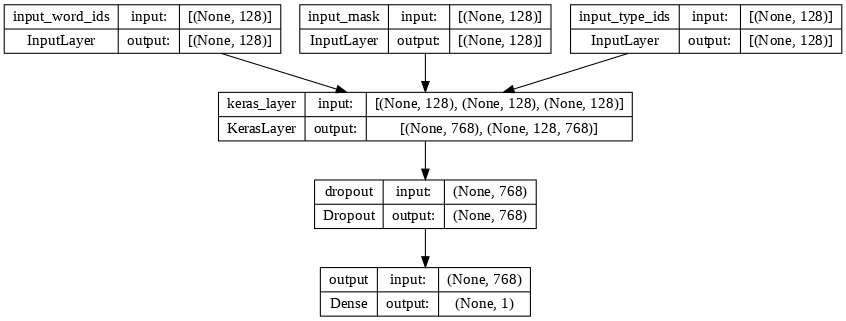

In [ ]:
tf.keras.utils.plot_model(model=model, show_shapes=True, dpi=76, )

In [ ]:
# Train model
epochs = 10
history = model.fit(train_data,
                    validation_data=valid_data,
                    epochs=epochs,
                    verbose=1)

Epoch 1/10
306/306 [==============================] - 269s 872ms/step - loss: 0.0972 - binary_accuracy: 0.9623 - val_loss: 0.1300 - val_binary_accuracy: 0.9573
Epoch 2/10
306/306 [==============================] - 268s 873ms/step - loss: 0.0520 - binary_accuracy: 0.9799 - val_loss: 0.1676 - val_binary_accuracy: 0.9531
Epoch 3/10
306/306 [==============================] - 268s 872ms/step - loss: 0.0228 - binary_accuracy: 0.9926 - val_loss: 0.2387 - val_binary_accuracy: 0.9521
Epoch 4/10
306/306 [==============================] - 267s 870ms/step - loss: 0.0134 - binary_accuracy: 0.9953 - val_loss: 0.2012 - val_binary_accuracy: 0.9521
Epoch 5/10
306/306 [==============================] - 268s 873ms/step - loss: 0.0082 - binary_accuracy: 0.9969 - val_loss: 0.2619 - val_binary_accuracy: 0.9573
Epoch 6/10
306/306 [==============================] - 268s 874ms/step - loss: 0.0087 - binary_accuracy: 0.9968 - val_loss: 0.2250 - val_binary_accuracy: 0.9594
Epoch 7/10
306/306 [====================

## Task 11: Evaluate the BERT Text Classification Model

In [ ]:
import matplotlib.pyplot as plt

def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])
  plt.show()

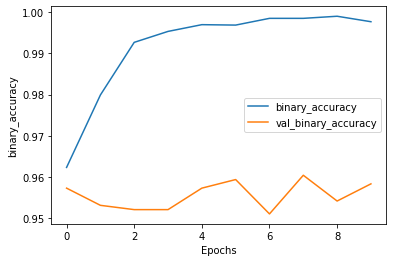

In [ ]:
plot_graphs(history, 'binary_accuracy')

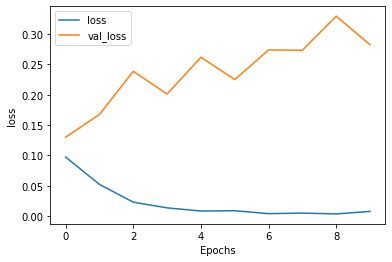

In [ ]:
plot_graphs(history, 'loss')

In [ ]:
model.evaluate(valid_data, verbose=1)

30/30 [==============================] - 9s 299ms/step - loss: 0.2826 - binary_accuracy: 0.9583


[0.2825920879840851, 0.9583333134651184]

In [ ]:
sample_example = [" ",\
                  " ",\
                  " ",\
                  " ",\
                  " ",\
                  " "]
test_data = tf.data.Dataset.from_tensor_slices((sample_example, [0]*len(sample_example)))
test_data = (test_data.map(to_feature_map).batch(1))
preds = model.predict(test_data)
#['Insincere' if pred >=0.5 else 'Sincere' for pred in preds]

6/6 [==============================] - 0s 11ms/step


In [ ]:
preds

array([[0.00142263],
       [0.00142263],
       [0.00142263],
       [0.00142263],
       [0.00142263],
       [0.00142263]], dtype=float32)